In [1]:
import pymc3 as pm
import theano.tensor as T
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import arviz as az
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [2]:
def posterior_grid_approx(grid_points=100, success=6, tosses=9): #a function to practice posterior grid approx
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    #prior = (p_grid >= 0.5).astype(int)  # truncated
    #prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

In [3]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [4]:
d2 = d[d.age >= 18]

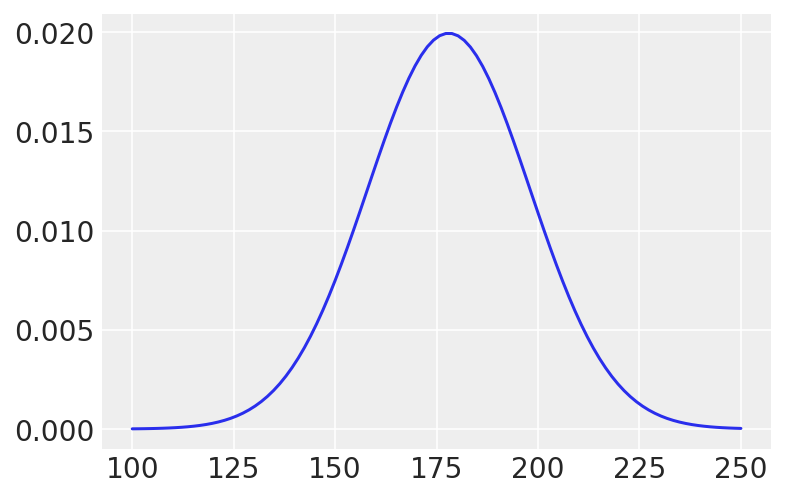

In [5]:
x = np.linspace(100, 250, 100) #inspecting our guesses at the prior distribution
plt.plot(x, stats.norm.pdf(x, 178, 20));

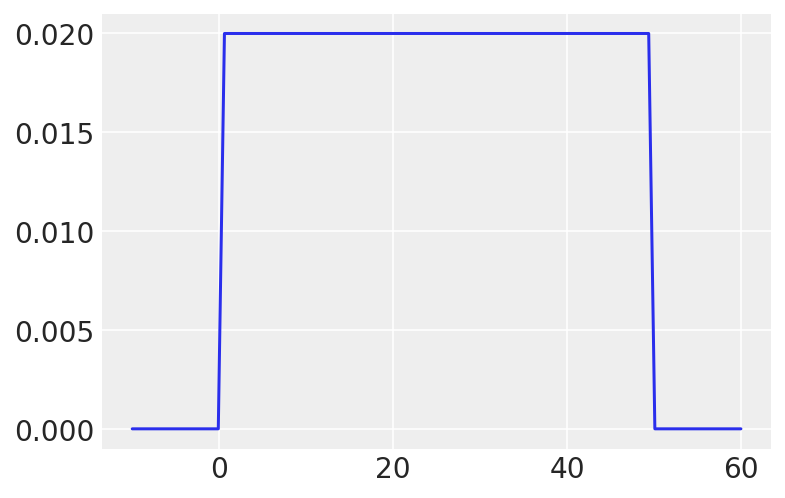

In [6]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

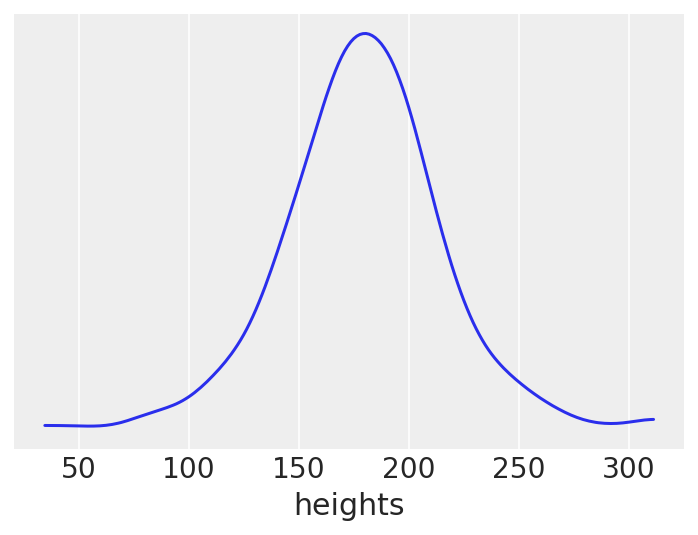

In [7]:
#prior predictive distribution: we came up with model and some prior distribtuions, so lets see what they say and compare with our data
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples) #this takes size n samples from N(178,20)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples) #this takes size n samples from uniform(0,50)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma) # 
az.plot_kde(prior_h)
plt.xlabel('heights')
plt.yticks([]);

In [8]:
#this is a grid approx which is not very good, just wxample
# post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

# likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

# post_prod = (likelihood + 
#              stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
#              stats.uniform.logpdf(post[:,1], loc=0, scale=50))
# post_prob = np.exp(post_prod - max(post_prod))

Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC3 comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN 'jitter+adapt_diag', which start with a identity mass matrix and then adapt a diagonal based on the variance of the tuning samples. 

In [9]:
with pm.Model() as m4_1: #this is how you define a pymc3 model
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)#other than the data being passed in here, this model does not depend on the data

In [10]:
with m4_1:# this simply takes a sample from our model.
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2038.92draws/s]


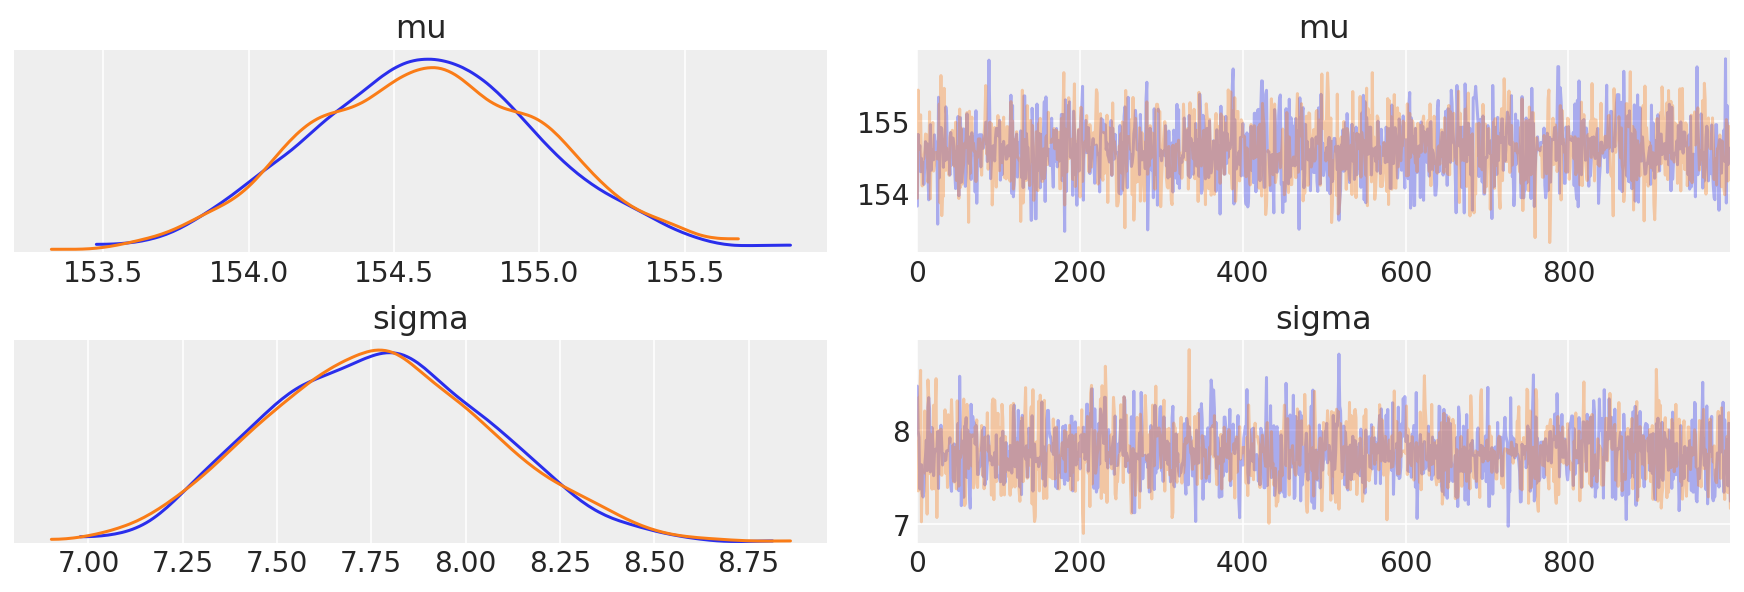

In [11]:
az.plot_trace(trace_4_1); # this function let you check the samples values

In [12]:
# with pm.Model() as m4_2: #this is just changing the prior sd to make it much less variable
#     mu = pm.Normal('mu', mu=178, sd=0.1)
#     sigma = pm.Uniform('sigma', lower=0, upper=50)
#     height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
#     trace_4_2 = pm.sample(1000, tune=1000)

In [13]:
# turn trace into df for manipulation
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov() #variance-covariance matrix

,mu,sigma
mu,0.163223,0.001642
sigma,0.001642,0.087672


In [14]:
#then we deccompose this matrix to understand it better
np.diag(trace_df.cov()) #variances

array([0.16322251, 0.08767167])

In [15]:
trace_df.corr() #correlation matrix

,mu,sigma
mu,1.000000,0.013729
sigma,0.013729,1.000000


In [16]:
 trace_df.head()

,mu,sigma
0,153.825271,8.472464
1,154.817845,7.990739
2,154.488839,7.924341
3,154.663760,7.375401
4,154.301349,7.570896


In [17]:
az.summary(trace_4_1, credible_interval=.89).round(2)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,154.61,0.4,153.97,155.26,0.01,0.01,2277.0,2277.0,2273.0,1437.0,1.0
sigma,7.77,0.3,7.29,8.23,0.01,0.00,1938.0,1930.0,1938.0,1472.0,1.0


Now lets add in an actual linear predictor variable

In [18]:
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight #this addition allows us to directly compare predictions with the data.
    #mu = pm.Deterministic('mu', alpha + beta * d2.weight) # try uncomenting this line and comenting the above line
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:08<00:00, 479.90draws/s]


In [19]:
#az.plot_trace(trace_4_3)

Now we use the full model to sample the posterior

In [20]:
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))# this next code block is 

In [21]:
with pm.Model() as m4_4:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1662.44draws/s]


In [22]:
az.summary(trace_4_4, credible_interval=.89).round(3) #summary table of posterior data

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,154.602,0.267,154.161,155.019,0.005,0.003,3196.0,3195.0,3151.0,1633.0,1.0
beta,0.907,0.043,0.839,0.974,0.001,0.001,2917.0,2917.0,2915.0,1408.0,1.0
sigma,5.106,0.189,4.796,5.391,0.004,0.002,2857.0,2857.0,2817.0,1529.0,1.0


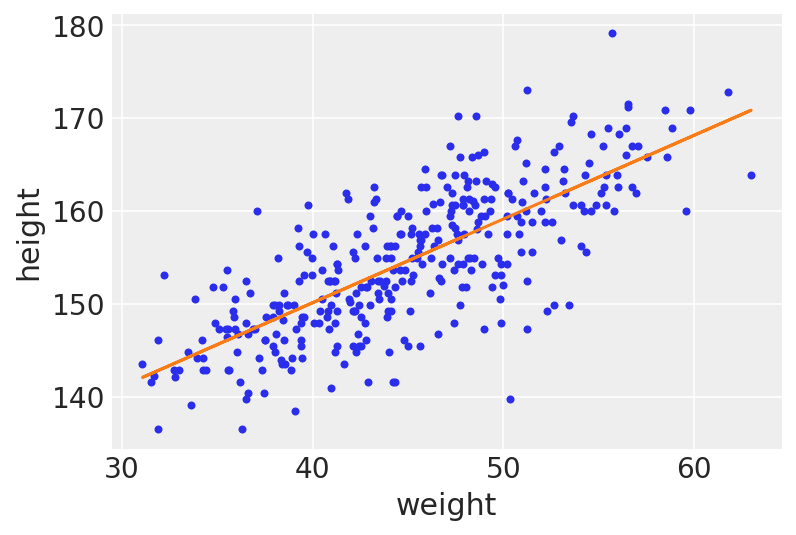

In [43]:
#graph of posterior data predictors and actual values
plt.plot(d2.weight, d2.height, '.')
plt.plot(d2.weight, trace_4_3['alpha'].mean() + trace_4_3['beta'].mean() * d2.weight)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

In [49]:
N = [10, 50, 150, 352][-2]
with pm.Model() as m_N:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight[:N])
    height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=d2.height[:N])
    trace_N = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 552.43draws/s]
The acceptance probability does not match the target. It is 0.8932763582850138, but should be close to 0.8. Try to increase the number of tuning steps.


In [50]:
chain_N = trace_N[100:]

The code below helps us visualize the whole posterior distribution, not just its best estimate.

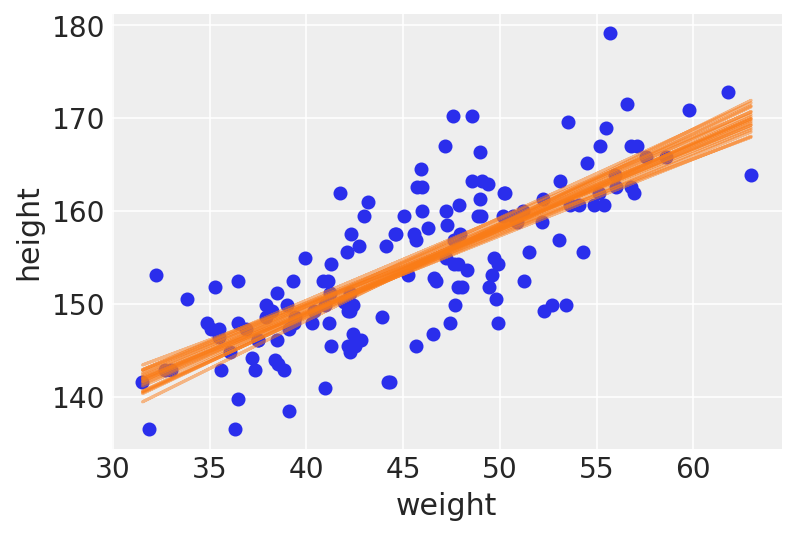

In [51]:
plt.plot(d2.weight[:N], d2.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['alpha'][idx] + chain_N['beta'][idx] * d2.weight[:N], 'C1-', alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

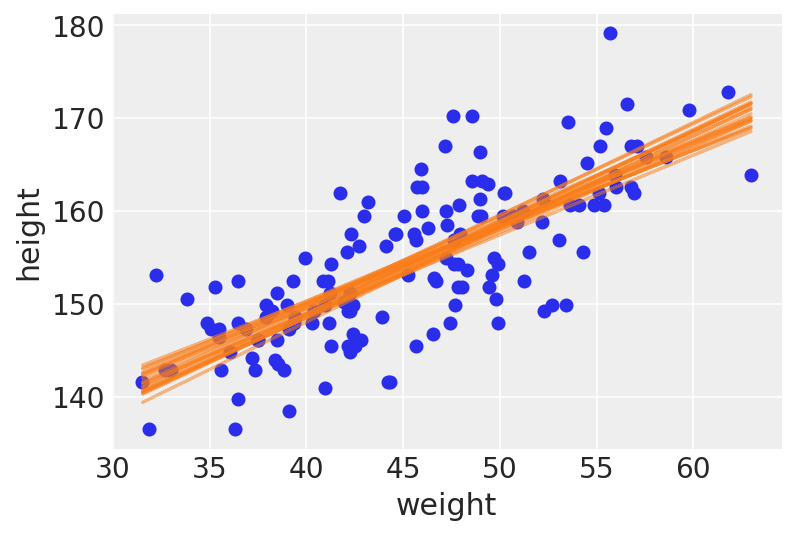

In [52]:
plt.plot(d2.weight[:N], d2.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['mu'][idx], 'C1-', alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

In [28]:
#this is instead of the link function in the book, this is code look at the uncertainty around the mean regression line.
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = chain_N[::10]
mu_pred = np.zeros((len(weight_seq), len(chain_N_thinned)*chain_N.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * w

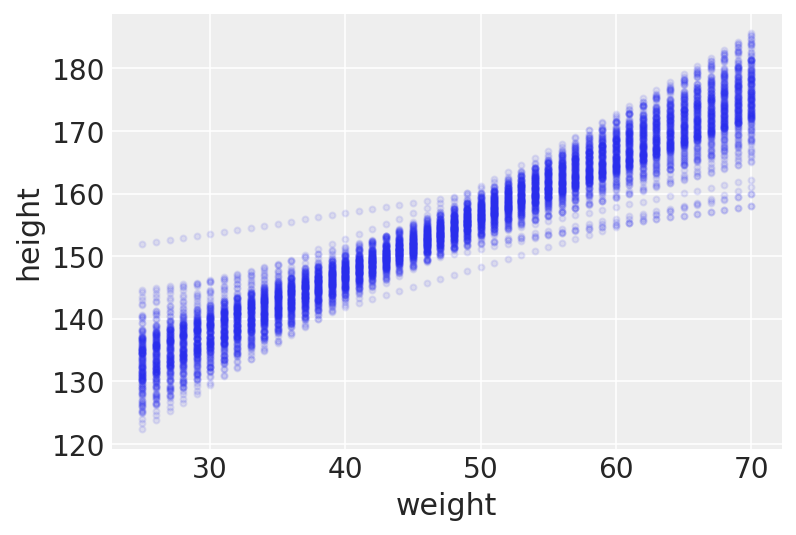

In [29]:
#this gives us hieght uncertainty
plt.plot(weight_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight')
plt.ylabel('height');

In [30]:
mu_mean = mu_pred.mean(1)
mu_hpd = az.hpd(mu_pred.T, credible_interval=.89)

/home/will/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


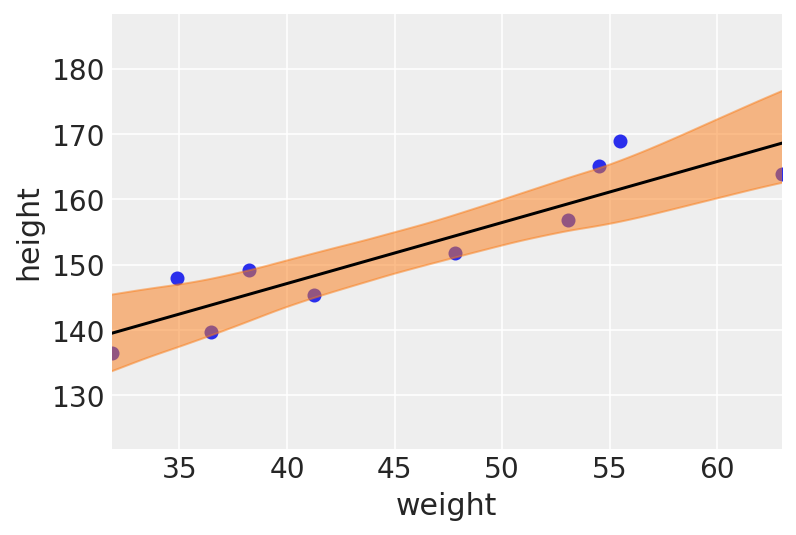

In [31]:
# this allows us to see the uncertainty in wiehgt as well. this is showing us the 89% CI around our best guess
plt.scatter(d2.weight[:N], d2.height[:N])
plt.plot(weight_seq, mu_mean, 'k')
az.plot_hpd(weight_seq, mu_pred.T)
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

Now we are sampling from the posterior to generate a prediction interval for actual heights, not just the average.
"This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. Thus in the following example the shape of height_pred['height_hat'].shape is (200, 352)"

In [32]:
height_pred = pm.sample_posterior_predictive(chain_N, 200, m_N)

100%|██████████| 200/200 [00:00<00:00, 766.53it/s]


In [33]:
#this finds the highest posterior density interval for the predictions sampled above
height_pred_hpd = az.hpd(height_pred['height_hat'])

/home/will/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


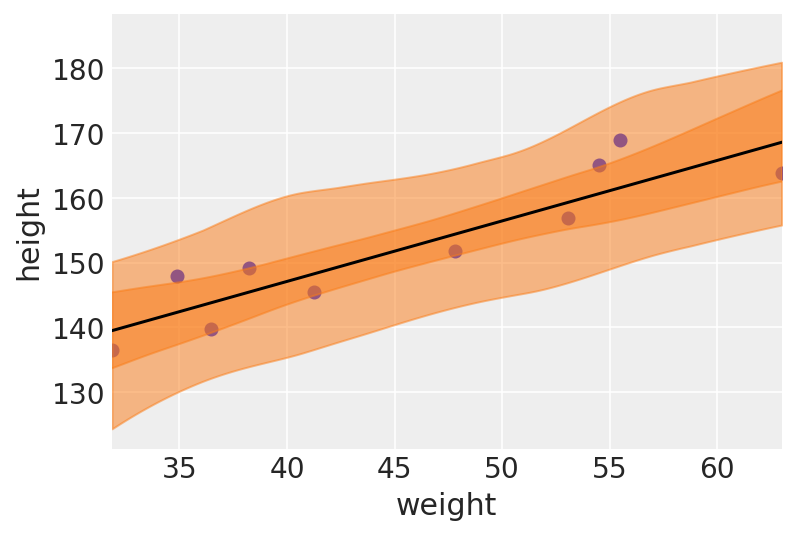

In [34]:


plt.scatter(d2.weight[:N], d2.height[:N])#plot raw data
az.plot_hpd(weight_seq, mu_pred.T)#draws hpdi region for the line
az.plot_hpd(d2.weight[:N], height_pred['height_hat']) #draws the pi region for the simulated heights
plt.plot(weight_seq, mu_mean, 'k') # #draw MAP line
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

Now we are going to move on to polynomial regression. to do this, we will go back to the whole data set that includes children

In [35]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std**2

In [36]:
with pm.Model() as m_4_5:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta[0] * d.weight_std + beta[1] * d.weight_std2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1024.27draws/s]


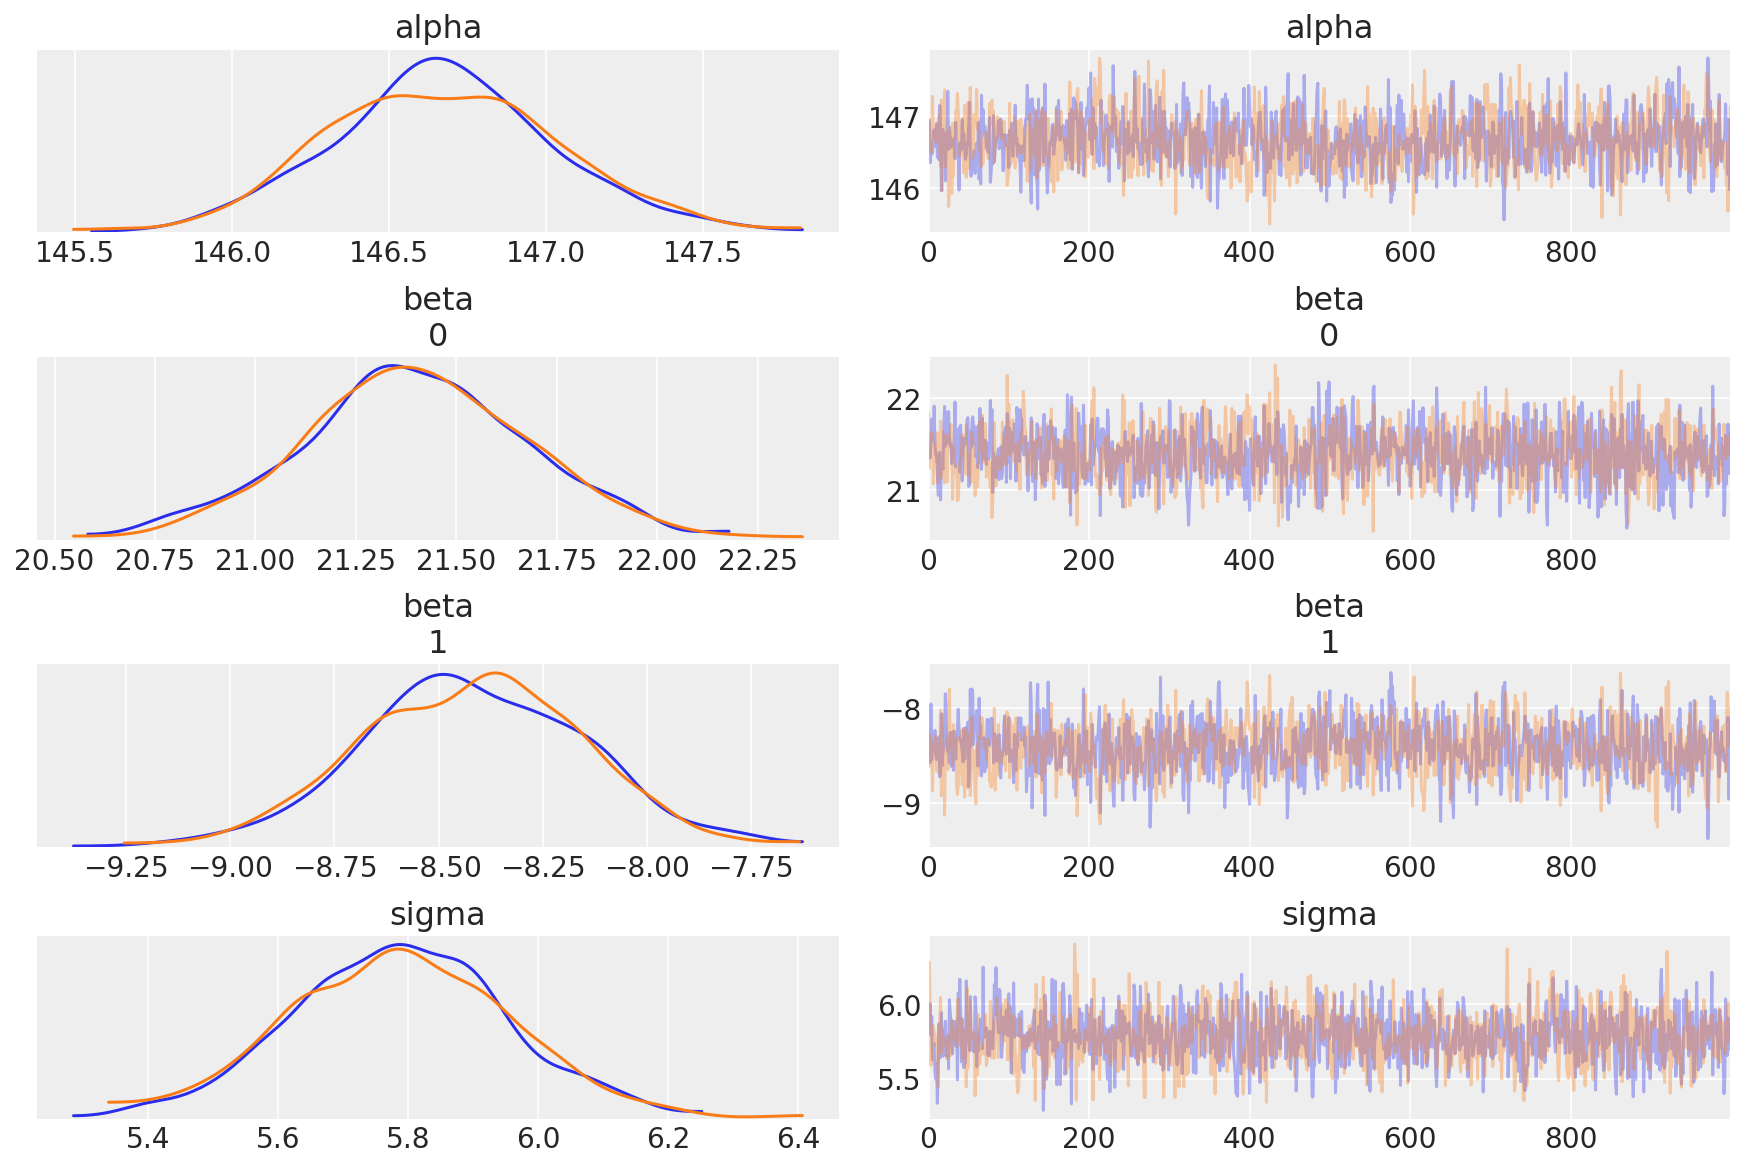

In [37]:
varnames = ['~mu']
az.plot_trace(trace_4_5, varnames);

In [38]:
mu_pred = trace_4_5['mu']
height_pred = pm.sample_ppc(trace_4_5, 200, m_4_5)

/home/will/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 200/200 [00:00<00:00, 630.02it/s]


/home/will/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


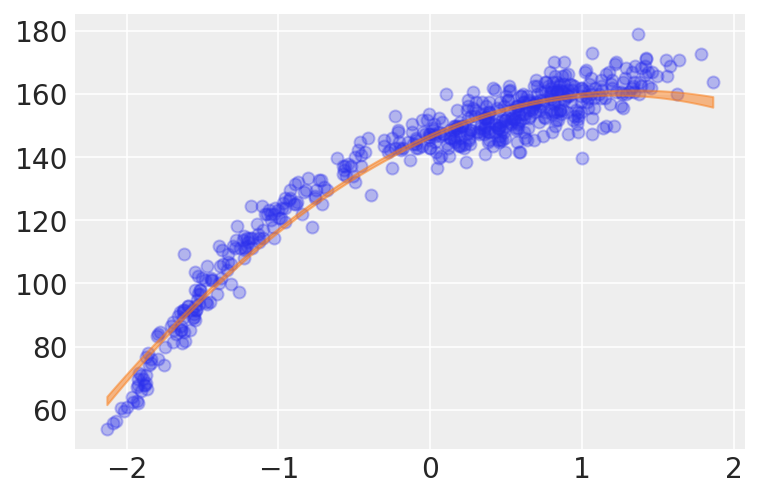

In [54]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
az.plot_hpd(d.weight_std, mu_pred, credible_interval=.89)
#az.plot_hpd(d.weight_std, height_pred['height'], credible_interval=.89)